In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-23 11:17:56.284491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 11:17:56.284508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df.describe()
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")
df.max()

LCLid                       MAC000181
tstp              2014-02-28 00:00:00
energy(kWh/hh)                  4.595
dtype: object

In [4]:
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [5]:
df["energy(kWh/hh)"].describe()
#df.max()
df.describe()

,energy(kWh/hh)
count,396552.000000
mean,0.217255
std,0.301549
min,0.000000
25%,0.068000
50%,0.118000
75%,0.251000
max,4.595000


In [6]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_92514/194026773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [7]:
hh["energy(kWh/hh)"].describe()
len(hh["energy(kWh/hh)"])

39719

In [8]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 48,
epochs = 40,
batch_size = 256,
train_test_split = 0.15
)

In [9]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/40


2022-03-23 11:17:59.448800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 11:17:59.449209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 11:17:59.449244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-23 11:17:59.449271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-23 11:17:59.449297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

132/132 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0195
Epoch 2/40
132/132 [==============================] - 0s 609us/step - loss: 0.0140 - val_loss: 0.0122
Epoch 3/40
132/132 [==============================] - 0s 546us/step - loss: 0.0097 - val_loss: 0.0089
Epoch 4/40
132/132 [==============================] - 0s 627us/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/40
132/132 [==============================] - 0s 656us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 6/40
132/132 [==============================] - 0s 591us/step - loss: 0.0058 - val_loss: 0.0060
Epoch 7/40
132/132 [==============================] - 0s 556us/step - loss: 0.0054 - val_loss: 0.0056
Epoch 8/40
132/132 [==============================] - 0s 698us/step - loss: 0.0051 - val_loss: 0.0053
Epoch 9/40
132/132 [==============================] - 0s 660us/step - loss: 0.0048 - val_loss: 0.0051
Epoch 10/40
132/132 [==============================] - 0s 558us/step - loss: 0.0047 - val_loss:

In [10]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


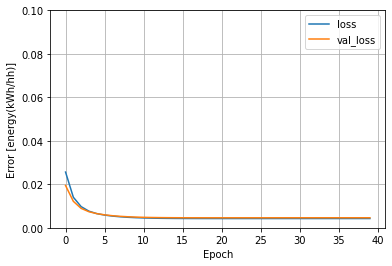

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [12]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

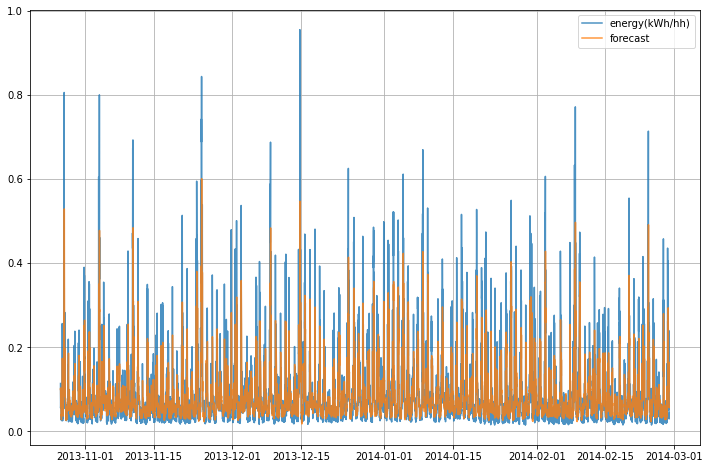

In [13]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_92514/2078647226.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


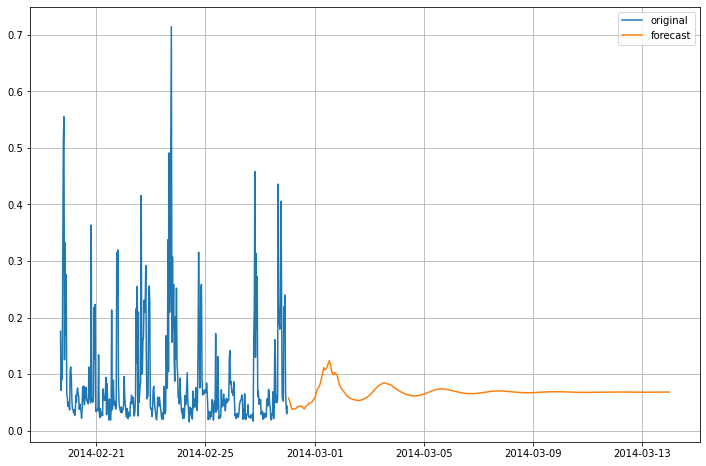

In [21]:

#Forecasting n steps ahead
n_ahead = 168*2
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [15]:
deep_learner.evaluateMSE()

0.004618165858619097

In [16]:
deep_learner.evaluateRMSE()

0.06795708836184124

In [17]:
deep_learner.evaluateMAE()

0.0364030325765166

In [18]:
deep_learner.evaluateMAPE()

44.789096388653476

In [19]:
yhat =deep_learner.predict()

In [20]:
yhat

[0.09995627,
 0.10336076,
 0.07042226,
 0.059476156,
 0.066673554,
 0.04950367,
 0.037151534,
 0.04008793,
 0.032593936,
 0.027905121,
 0.03338527,
 0.036733896,
 0.03923119,
 0.04124727,
 0.039648633,
 0.051095434,
 0.049852755,
 0.1142283,
 0.1736666,
 0.16087833,
 0.13041309,
 0.07042089,
 0.05639872,
 0.07206035,
 0.07543121,
 0.055044156,
 0.04664707,
 0.036559064,
 0.068164825,
 0.11041021,
 0.08271045,
 0.11605869,
 0.088118404,
 0.22511408,
 0.2653154,
 0.27709338,
 0.2911302,
 0.5292229,
 0.2678905,
 0.23857024,
 0.1692495,
 0.1603125,
 0.1841656,
 0.14850879,
 0.19638479,
 0.15095323,
 0.14257711,
 0.079773866,
 0.076511785,
 0.0773111,
 0.06624554,
 0.052084863,
 0.043264113,
 0.03167145,
 0.026340606,
 0.03219546,
 0.03658787,
 0.036675587,
 0.036741674,
 0.039403602,
 0.032564465,
 0.038742166,
 0.028511874,
 0.045639515,
 0.047318447,
 0.049907338,
 0.059989996,
 0.059811275,
 0.05374309,
 0.04792399,
 0.060653996,
 0.06923088,
 0.052909058,
 0.051231787,
 0.12077972,
 0.